# Overview
The beginning of this notebook is all about fetching data alongside formatting it.
If you only care about the data analysis then go to anything after example use.

## Imports

In [ ]:
!pip install --upgrade quandl
import pandas as pd # dataframes
import quandl # data feed
import os.path # save file capability
from os import path # check version capability
from datetime import date # check version capability
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


Requirement already up-to-date: quandl in /usr/local/lib/python3.7/dist-packages (3.6.1)


# WASDE Data Class

In [ ]:
# Created by Maximo Xavier DeLeon
class WasdeClient:

  def __init__(self,quandl_api_key=None):
    self.today = date.today() # get the current date
    if type(quandl_api_key) is not None: # if the user has a quandl api key then use it
      quandl.ApiConfig.api_key = quandl_api_key # set the api key
    else: pass # ignore if there's no api key
    self.check_pull() # check if the wasde csv file exists and if it has been updated today
    self.commodity_list = [commodity for commodity in  self.wasde_data.commodity.unique()] # create a list of commodities in the wasde from the unique values in the commmodity column
    self.region_list = [region for region in  self.wasde_data.region.unique()] # create a list of regions in the wasde from the unique values in the region column

  # checks if the wasde csv file has been downloaded today by seeing if the csv exists and if the text file for the previous update date exists
  def check_pull(self,date_file='datefile.txt'):
    check_line = 'LAST UPDATED ON: ' + str(self.today) # this is what we are looking for in the text file to ensure our wasde csv file is updated
    if path.exists(date_file) and path.exists('WASDE_DATA.csv'):
      with open(date_file) as file: # read the text file - credit to vt cs1064 for teaching me this
        content = file.read().splitlines()

      if check_line not in content: # check if the file's update check matches the one generated
        file_to_change = open(date_file, 'w') #open/create a file
        file_to_change.write(check_line) # write the current date
        file_to_change.close() # close the file
        wasde_data = quandl.get_table("WASDE/DATA", paginate=True) # pull the data from quandl
        self.wasde_data = wasde_data.drop(['min_value',	'max_value'], axis=1) # drop the empty columns
        self.wasde_data.to_csv('WASDE_DATA.csv') # write the data to a csv file and save it

      else: self.wasde_data = pd.read_csv('WASDE_DATA.csv') # if the file has been updated already and or the wasde csv file is in the directory then open the csv and make df

    else:
      file_to_change = open(date_file, 'w') # open/create a file
      file_to_change.write(check_line) # write the line into the file
      file_to_change.close() # close the file
      wasde_data = quandl.get_table("WASDE/DATA", paginate=True) # pull the data from quandl
      self.wasde_data = wasde_data.drop(['min_value',	'max_value'], axis=1) # drop the empty columns
      self.wasde_data.to_csv('WASDE_DATA.csv') # write the data to a csv file and save it


  # returns wasde report data for a user defined agriculture commodity and region
  def query(self,commodity, region, world_summary=False,cleaned=True):
    if commodity in self.commodity_list and region in self.region_list:
      world_summary = True if region != 'United States' else world_summary # is the country is not the united states then set the ~world~ report option to true
      query_df = self.wasde_data.loc[(self.wasde_data.commodity == commodity) & (self.wasde_data.region == region)] # query the specific commodity and region
      query_df['is_world'] = self.wasde_data.code.str.contains(pat = 'WORLD') # create a tag for the report id to index for united states condition

      if region == 'United States' and world_summary is True:
        query_df = query_df.loc[query_df.is_world == True] # index rows that have the world summary tag
        query_df = query_df.drop(['is_world'], axis=1) # drop the indexing column
        return self.format(df=query_df,fancy=cleaned) # return the commodity wasde data

      elif region == 'United States' and world_summary is False:
        query_df = query_df.loc[query_df.is_world == False] # index rows that do not have the world summary tag
        query_df = query_df.drop(['is_world'], axis=1) # drop the indexing column
        return self.format(df=query_df,fancy=cleaned) # return the commodity wasde data

      else:
        query_df = query_df.drop(['is_world'], axis=1) # drop the indexing column
        return self.format(df=query_df,fancy=cleaned) # return the commodity wasde data

  # method to split up the returned dataframes into something less confusing to work with
  def format(self,df,fancy=True):
    # dictionary to store the 3 types of values the WASDE will return for each report
    wasde_frame_configs = {'current_year': (df.year.str.contains(pat= 'Proj') == True) & (df.year.str.contains(pat= 'Est') == False),
                        'last_year': (df.year.str.contains(pat= 'Proj') == False) & (df.year.str.contains(pat= 'Est') == True),
                        'two_years_ago': ( df.year.str.contains(pat= 'Proj') == False) & (df.year.str.contains(pat= 'Est') == False)}
    returned_dataframes = [] # store the dataframes to be split in here
    month_dict = {'May':5, 'Mar':3, 'Apr':4, 'Feb':2, 'Jan':1, 'Dec':12, 'Nov':11, 'Oct':10, 'Sep':9, 'Aug':8, 'Jul':7, 'Jun':6, 'Annual': 'Annual' } # dictionary coverting text month into numerical
    for wasde_config in wasde_frame_configs: # iterate through the dictionary
      df.loc[wasde_frame_configs[wasde_config] == True, 'estimate_type'] = wasde_config # conditional formatting to label the values
      if wasde_config == 'current_year':
        df.period = df.period.map(month_dict)  # conditional formatting to label the values
        df.drop(df[(pd.DatetimeIndex(df.report_month).month != df.period) & (df.period != 'Annual')].index, inplace = True) # remove the rows for the previous month estimate
      else: pass

      returned_dataframes.append(df.loc[df.estimate_type == wasde_config]) # append the dataframe to a list

    if fancy: 
        df_to_clean_list = [dirty_df.drop(['region','commodity','estimate_type','code','year'],axis=1) for dirty_df in returned_dataframes] # remove the information we don't need
        returned_dataframes = [] # clear the list of "dirty" dataframes so we can put our clean ones in
        for current_df in df_to_clean_list: # iterate thorugh the list of dataframes
          report_date_list = current_df.report_month.unique() # creates a list of report releases
          items = current_df.item.unique() # create a list of items that are unique in describing crop data
          report_list = [] # this is where we will store our new dataframe rows
          for report in report_date_list: # iterate trhough each monthly report
            value_list = current_df.value.loc[current_df.report_month == report].to_list() # grab the values being used for each monthly report
            item_list = current_df.item.loc[current_df.report_month == report].to_list() # grab the items to pair with the corresponding values
            zip_object = zip(item_list,value_list) # zip the two values
            current_row = dict(zip_object) # create a dictionary for the current row
            report_list.append(current_row)  # append the dictionary as an element in our list
          cleaned_df = pd.DataFrame(data = report_list, columns=items, index=report_date_list) # build our dataframe with our nested dictionaries for each report
          cleaned_df = cleaned_df.drop('Residual 5/',axis=1)
          returned_dataframes.append(cleaned_df.iloc[::-1]) # append the dataframe to our return list then
    else: pass

    return (returned_dataframes[0], returned_dataframes[1], returned_dataframes[2]) # return the different dataframes as tuples

# Example Usage: Soybean
Basic example of using the WasdeClient class. Enter the name of a supported commodity, supported region. If the region is the United States then there's the option to select the world data and the domestic data by toggling True/False. By default the world_summary parameter is set to False.

Create an instance of our class to acess data from USDA WASDE reports

In [ ]:
report = WasdeClient(quandl_api_key='APIKEY') # create an instance of the wasde client class

Query the soybean reports from our object's dataframe

In [ ]:
soybean_data_list = report.query(commodity='Soybeans', region='United States', world_summary=False,cleaned=True) # query our soybean data into a tuple
beans_current_year, beans_last_year, beans_two_years_ago = soybean_data_list # assign each nested dataframe in the list to an actual variable
soybean_fundementals = beans_current_year.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Data Exploration



begin by renaming the net supply and demand columns to something more easily typeable.
Create a column for ending stocks predicted by the USDA
Create a column that stores a stocks to use ratio for each monthly report

In [ ]:
from datetime import datetime, timedelta
soybean_fundementals = soybean_fundementals.rename(columns={'Use, Total (Crushings+Exports+Seed+Residual)':'Total Use', 'Supply, Total (Beginning Stocks+Production+Imports)':'Total Supply','Avg. Farm Price ($/bu) 2/':'Avg Price ($/bu)'})
soybean_fundementals['Ending Stocks'] = soybean_fundementals['Total Supply'] - soybean_fundementals['Total Use']
soybean_fundementals['Stocks to Use'] = ((soybean_fundementals['Total Supply'] - soybean_fundementals['Total Use']) / soybean_fundementals['Total Supply'])
soybean_fundementals['Inverse Stocks to Use'] = 1/soybean_fundementals['Stocks to Use']
beans_current_year = soybean_fundementals.copy()

beans_current_year.index = pd.DatetimeIndex(beans_current_year.index).to_period('M') # reformat the index to show year and month

beans_current_year.head()

,Total Use,Total Supply,Seed,Residual,Production,Imports,Exports,Ending Stocks,Crushings,Beginning Stocks,Avg Price ($/bu),Yield per Harvested Acre,Area Planted,Area Harvested,Stocks to Use,Inverse Stocks to Use
2010-08,3243.0,3603.0,88.0,70.0,3433.0,10.0,1435.0,360.0,1650.0,160.0,NaN,44.0,78.9,78.0,0.099917,10.008333
2011-01,3355.0,3495.0,88.0,22.0,3329.0,15.0,1590.0,140.0,1655.0,151.0,NaN,43.5,77.4,76.6,0.040057,24.964286
2011-02,3355.0,3495.0,88.0,22.0,3329.0,15.0,1590.0,140.0,1655.0,151.0,NaN,43.5,77.4,76.6,0.040057,24.964286
2011-03,3355.0,3495.0,91.0,19.0,3329.0,15.0,1590.0,140.0,1655.0,151.0,NaN,43.5,77.4,76.6,0.040057,24.964286
2011-04,3355.0,3495.0,89.0,36.0,3329.0,15.0,1580.0,140.0,1650.0,151.0,NaN,43.5,77.4,76.6,0.040057,24.964286


Get the cash price of soybeans

In [ ]:
soybean_continuous_contract = quandl.get("CHRIS/CME_S4")
#cash_price = quandl.get("TFGRAIN/SOYBEANS", authtoken="mssPioTZC2BM3ASfjiFE") # pull the data from quandl
soybean_futures_price = soybean_continuous_contract.resample('M').mean() # resample from daily to monthly and average the values for each month
soybean_futures_price.index = pd.DatetimeIndex(soybean_futures_price.index).to_period('M') # reformat the index to show year and month

start_month = beans_current_year.index[0] # get the time for the start of our wasde data
end_month = beans_current_year.index[-1] # get the time for the end of our wasde data

masked_soybean_futures_price = soybean_futures_price.loc[(soybean_futures_price.index >= start_month) & (soybean_futures_price.index <= end_month)]

if 'Settle' not in beans_current_year.columns:
  beans_current_year = beans_current_year.join(masked_soybean_futures_price)
beans_current_year.head()

,Total Use,Total Supply,Seed,Residual,Production,Imports,Exports,Ending Stocks,Crushings,Beginning Stocks,Avg Price ($/bu),Yield per Harvested Acre,Area Planted,Area Harvested,Stocks to Use,Inverse Stocks to Use,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
2010-08,3243.0,3603.0,88.0,70.0,3433.0,10.0,1435.0,360.0,1650.0,160.0,NaN,44.0,78.9,78.0,0.099917,10.008333,1029.340909,1033.113636,1026.170455,1029.772727,NaN,1029.772727,8333.954545,45615.500000
2011-01,3355.0,3495.0,88.0,22.0,3329.0,15.0,1590.0,140.0,1655.0,151.0,NaN,43.5,77.4,76.6,0.040057,24.964286,1397.162500,1405.450000,1391.937500,1396.700000,NaN,1396.700000,11787.550000,41930.950000
2011-02,3355.0,3495.0,88.0,22.0,3329.0,15.0,1590.0,140.0,1655.0,151.0,NaN,43.5,77.4,76.6,0.040057,24.964286,1393.828947,1400.368421,1387.289474,1392.184211,NaN,1392.184211,1483.842105,5902.684211
2011-03,3355.0,3495.0,91.0,19.0,3329.0,15.0,1590.0,140.0,1655.0,151.0,NaN,43.5,77.4,76.6,0.040057,24.964286,1356.043478,1361.228261,1350.760870,1356.304348,NaN,1356.304348,2364.478261,10018.695652
2011-04,3355.0,3495.0,89.0,36.0,3329.0,15.0,1580.0,140.0,1650.0,151.0,NaN,43.5,77.4,76.6,0.040057,24.964286,1370.775000,1372.462500,1369.187500,1371.312500,NaN,1371.312500,2835.300000,14639.600000


# Stocks to Use and Cash Price Plot

Plot the ending stocks to use ratio alongside the cash price of soybeans

Text(0.0, 1.0, 'Soybean: Stocks to Use Ratio and Continuous Contract Price from 2010-08 to 2021-05')

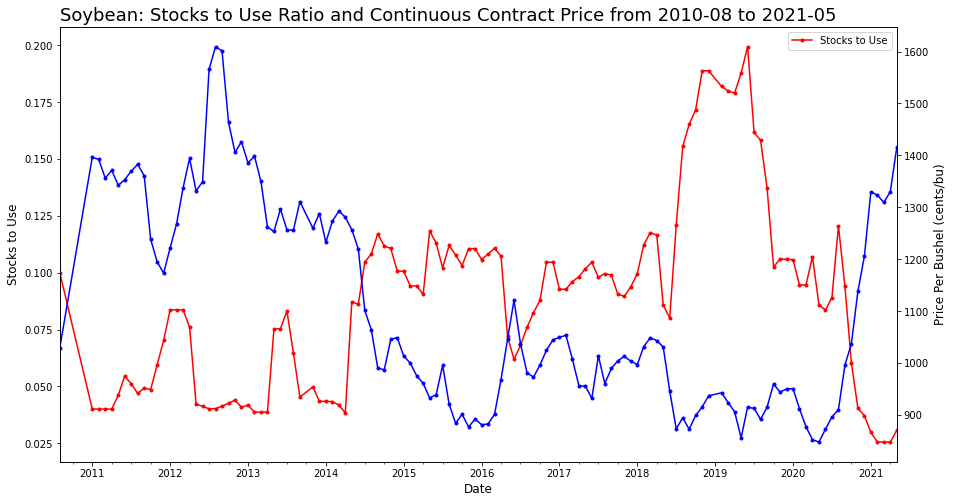

In [ ]:
ax = beans_current_year.plot(y='Stocks to Use',style='.-', color='red')

beans_current_year['Settle'].plot(secondary_y=True,ax=ax, figsize=(15,8),style='.-', color='blue')
plt.ylabel('Price Per Bushel (cents/bu)', fontsize='12')
ax.set_ylabel('Stocks to Use', fontsize='12')

ax.set_xlabel('Date', fontsize='12')
date_range = str(start_month) + ' to ' + str(end_month)
plt.title('Soybean: Stocks to Use Ratio and Continuous Contract Price from ' + date_range ,fontsize=18,loc='left')

# Set the y-axis label


Continouous Contract price vs Ending Stocks to Use Ratio

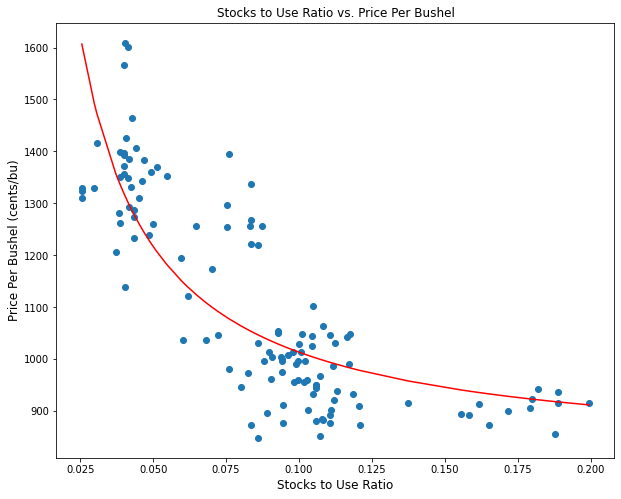

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

scatter_df = beans_current_year[['Stocks to Use', 'Settle']].dropna(axis=0)
X = 1/scatter_df['Stocks to Use'].values.reshape(-1, 1)
Y = scatter_df['Settle'].values.reshape(-1, 1)


linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

scat_ax = beans_current_year.plot.scatter(x='Stocks to Use', y='Settle',figsize=(10,8))

def best_fit (x,coef,intercept):
  return (1/X)*coef + intercept

X =1/X
plt.scatter(X, Y)
plt.ylabel('Price Per Bushel (cents/bu)',fontsize=12)
plt.xlabel('Stocks to Use Ratio',fontsize=12)
plt.title('Stocks to Use Ratio vs. Price Per Bushel',fontsize=12)
x_test = np.arange(0, 0.2)
best_fit_y = best_fit(X, linear_regressor.coef_, linear_regressor.intercept_)

new_x, new_y = zip(*sorted(zip(X, best_fit_y)))

plt.plot(new_x,new_y, color='red')

#Stocks to Use Ratio vs cash price

### Supply Side Area Plot

Text(0.0, 1.0, 'Soybean: Production Estimates 2010-08 to 2021-05')

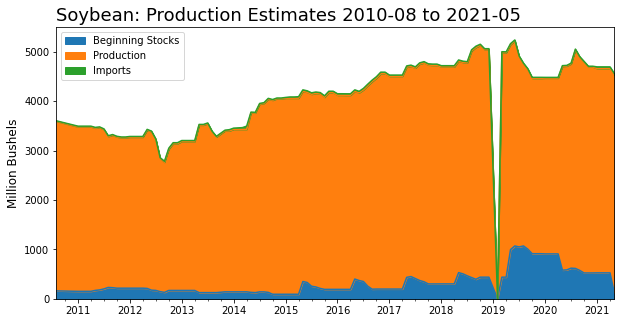

In [ ]:
ax2 = beans_current_year[['Beginning Stocks','Production', 'Imports']].plot.area(figsize=(10,5))
plt.ylabel('Million Bushels', fontsize='12')
plt.title('Soybean: Production Estimates ' + date_range ,fontsize=18,loc='left')

### Harvest Plot

Text(0.0, 1.0, 'Soybean: Acreage Estimates 2010-08 to 2021-05')

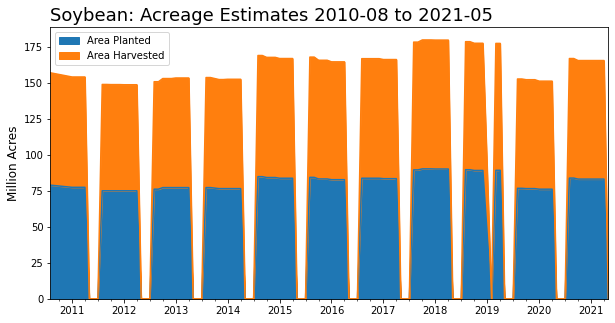

In [ ]:
ax3 = beans_current_year[['Area Planted','Area Harvested']].plot.area(figsize=(10,5))
plt.ylabel('Million Acres', fontsize='12')
plt.title('Soybean: Acreage Estimates ' + date_range ,fontsize=18,loc='left')

### Demand Side Area Plot

Text(0.0, 1.0, 'Soybean: Use Estimates 2010-08 to 2021-05')

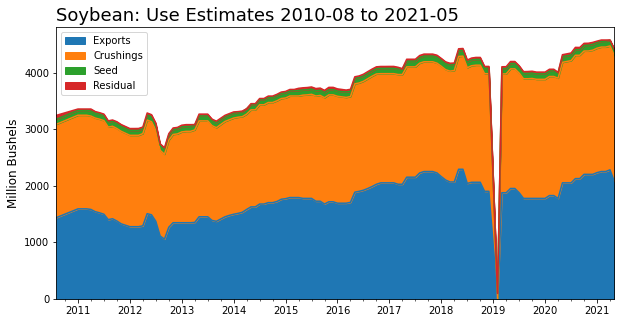

In [ ]:
ax3 = beans_current_year[['Exports','Crushings', 'Seed', 'Residual']].plot.area(figsize=(10,5))
plt.ylabel('Million Bushels', fontsize='12')
plt.title('Soybean: Use Estimates ' + date_range ,fontsize=18,loc='left')